In [1]:
import pandas
import glob
import sqlalchemy
import numpy
print(pandas.__version__)

#from folium.plugins import MarkerCluster # for clustering the markers
import plotly.express as px
import plotly.graph_objects as go

# 
pandas.set_option('max_columns', None)

1.3.4


In [2]:
def load_smard_data(
    ee_type:str = "Photovoltaik", 
    anzulegender_Marktwert:float = 5, 
    data_path:str=r"/home/werleinm/Dokumente/Test-code/cfd/smard_data"):
    """Load smard data from a given directory and join them with Marktwerten on in common time format."""
    # GROSSHANDELSPREISE
    all_files = glob.glob(data_path  + "/Gro*.csv")
    li = []

    for filename in all_files:
        df = pandas.read_csv(filename, delimiter=";", na_values="-",decimal=",", parse_dates={"date":["Datum","Uhrzeit"]}, dayfirst=True)

        # rename columns containing data to germany
        if "Deutschland/Luxemburg[€/MWh]" in df.columns:
            df = df.rename(columns={"Deutschland/Luxemburg[€/MWh]":"Gro_handelspreis[€/MWh]"})
        if "Deutschland/Österreich/Luxemburg[€/MWh]" in df.columns:
            df = df.rename(columns={"Deutschland/Österreich/Luxemburg[€/MWh]":"Gro_handelspreis[€/MWh]"})
            
        # drop columns which contain nothing but NaN values
        df = df.dropna(axis=1, how='all')

        li.append(df)

    df = pandas.concat(li, axis=0, ignore_index=True)

    df = df.set_index("date")

    for column in df.columns:
        if df[column].dtype == "object":
            df[column] = df[column].str.replace(".","")
            df[column] = df[column].str.replace(",",".")
            df[column] = df[column].astype("float")

    grohandel = df[~df.index.duplicated(keep='first')]

    # ERZEUGUNG
    all_files = glob.glob(data_path  + "/Real*.csv")
    li = []

    for filename in all_files:
        df = pandas.read_csv(filename, delimiter=";", na_values="-", decimal=",", parse_dates={"date":["Datum","Uhrzeit"]}, dayfirst=True)
        li.append(df)

    df = pandas.concat(li, axis=0, ignore_index=True)

    df = df.set_index("date")

    for column in df.columns:
        if df[column].dtype == "object":
            df[column] = df[column].str.replace(".","")
            df[column] = df[column].str.replace(",",".")
            df[column] = df[column].astype("float")

    Erzeugung = df[~df.index.duplicated(keep='first')]# #.resample("4h").sum() #.head(n=10)
    Erzeugung = Erzeugung.resample("1h").sum()

    df = pandas.concat([grohandel["Gro_handelspreis[€/MWh]"], Erzeugung[f"{ee_type}[MWh]"]], axis=1)

    marktwerte = {
        "Jahresmarktwerte":{
            "Einheit":"ct/kWh",
            "PV":{
                "Jahr":[2020,2021],
                "Jahresmarktwert":[2.458,7.552]
            },
            "Wind":{
                "Jahr":[],
                "Jahresmarktwert":[]
            }
        },
        "tatsächlicher Jahresmarktwert":{
            "Einheit":"ct/kWh",
            "PV":{
                "Jahr":[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                "Jahresmarktwert":[4.495,3.936,3.333,3.171,2.956,3.474,4.515,3.776,2.897,9.562, 0],
                "anzulegender Wert":[]
            },
            "Wind":{
                "Jahr":[],
                "Jahresmarktwert":[]
            }

        }
    }

    lenList = len(marktwerte["tatsächlicher Jahresmarktwert"]["PV"]["Jahr"])
    marktwerte["tatsächlicher Jahresmarktwert"]["PV"]["anzulegender Wert"] = [anzulegender_Marktwert] * lenList

    PV_marktwerte = pandas.DataFrame(marktwerte["tatsächlicher Jahresmarktwert"]["PV"])

    PV_marktwerte["Jahr"] = pandas.to_datetime(PV_marktwerte["Jahr"], format="%Y")
    PV_marktwerte = PV_marktwerte.rename(columns={"Jahr":"date"})
    PV_marktwerte = PV_marktwerte.set_index("date")

    PV_marktwerte = PV_marktwerte.add_prefix("PV_")
    PV_marktwerte = PV_marktwerte.add_suffix(" [€/MWh]")
    PV_marktwerte = PV_marktwerte / 100 * 1000 # ct/kWh in €/MWh

    PV_marktwerte = PV_marktwerte.resample("1h").ffill()[:-1]

    return pandas.concat([PV_marktwerte, df], axis=1, join="inner")

## Jour-Fix BMWK 22.02.2022

- mit Wälzug für Neuanlagen, nicht für Altanlagen, ins Rennen gehen nach Absprache mit Syr
- EE Nutzung Straffreiheit. Wenn Kommunen beteiligt, landest du nicht im Gefängniss
- Bürgerenergie MW Grenze:
    - eine BÜWEA pro Vorrangsgebiet
    - BNK frist auf 2024 verlängert
- Ausschreibungen für Biomasse im Streit. IK33 will ganz raus haben
- AgriPV, keine Mohrböden zur Anwendung
- 11.03 schriftliche Stellungname der Länder
- ST-Sitzung am 18.03 Austausch mit den Ländern

- wollen wir uns mehr in Börsenpreis prognose einbinden
    - Ausbaurahmen bis 2050
    - Energy Brain Pool Szenarien
    - BMWK bindet gibt uns Ergebnisse weiter, wenn vorhanden

- cfds für PV kommen in Oster-Novelle sicher, Wind sind vielleicht noch zu kippen
    - Max und Matthis sollen zum Meeting die Woche beide dazu kommen

# Laden der einzelnen Datensätze unterschiedlicher .csv Daten

Als erste werden die Großhandelspreise eingeladen. Hierbei ist das famose Punkt-Komma Problem von deutschen tabellarischen Daten zu beachten!

In [3]:
# Path to csv files
CSV_PATH = r"/home/werleinm/Dokumente/Test-code/cfd/smard_data"

 # use your path
all_files = glob.glob(CSV_PATH  + "/Gro*.csv")

li = []

for filename in all_files:
    df = pandas.read_csv(filename, delimiter=";", na_values="-",decimal=",", parse_dates={"date":["Datum","Uhrzeit"]}, dayfirst=True)

    # rename columns containing data to germany
    if "Deutschland/Luxemburg[€/MWh]" in df.columns:
        df = df.rename(columns={"Deutschland/Luxemburg[€/MWh]":"Gro_handelspreis[€/MWh]"})
    if "Deutschland/Österreich/Luxemburg[€/MWh]" in df.columns:
        df = df.rename(columns={"Deutschland/Österreich/Luxemburg[€/MWh]":"Gro_handelspreis[€/MWh]"})
        
    # drop columns which contain nothing but NaN values
    df = df.dropna(axis=1, how='all')

    li.append(df)

df = pandas.concat(li, axis=0, ignore_index=True)

df = df.set_index("date")

for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.replace(".","")
        df[column] = df[column].str.replace(",",".")
        df[column] = df[column].astype("float")

grohandel = df[~df.index.duplicated(keep='first')]
grohandel

,Dänemark 1[€/MWh],Dänemark 2[€/MWh],Frankreich[€/MWh],Italien (Nord)[€/MWh],Niederlande[€/MWh],Polen[€/MWh],Schweden 4[€/MWh],Schweiz[€/MWh],Slowenien[€/MWh],Tschechien[€/MWh],Ungarn[€/MWh],Gro_handelspreis[€/MWh],Belgien[€/MWh],Norwegen 2[€/MWh],Österreich[€/MWh]
date,,,,,,,,,,,,,,,
2015-01-01 00:00:00,25.02,27.38,NaN,NaN,NaN,NaN,27.38,44.94,27.30,26.48,45.07,NaN,NaN,27.40,NaN
2015-01-01 01:00:00,18.29,18.29,NaN,NaN,NaN,NaN,23.37,43.43,23.25,24.20,44.16,NaN,NaN,27.07,NaN
2015-01-01 02:00:00,16.04,16.04,NaN,NaN,NaN,NaN,19.33,38.08,22.20,22.06,39.17,NaN,NaN,26.93,NaN
2015-01-01 03:00:00,14.60,14.60,NaN,NaN,NaN,NaN,17.66,35.47,19.56,20.27,26.93,NaN,NaN,26.83,NaN
2015-01-01 04:00:00,14.95,14.95,NaN,NaN,NaN,NaN,17.53,30.83,18.88,19.17,20.94,NaN,NaN,26.81,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 19:00:00,140.28,140.28,140.28,214.66,140.28,140.28,140.28,137.76,140.28,140.28,140.28,140.28,140.28,143.81,140.28
2022-01-01 20:00:00,121.88,121.88,121.88,214.66,121.88,121.88,121.88,128.55,121.88,121.88,121.88,121.88,121.88,140.36,121.88
2022-01-01 21:00:00,102.61,102.61,102.61,203.00,102.61,102.61,102.61,140.62,102.61,102.61,102.61,102.61,102.61,139.85,102.61


<AxesSubplot:xlabel='date'>

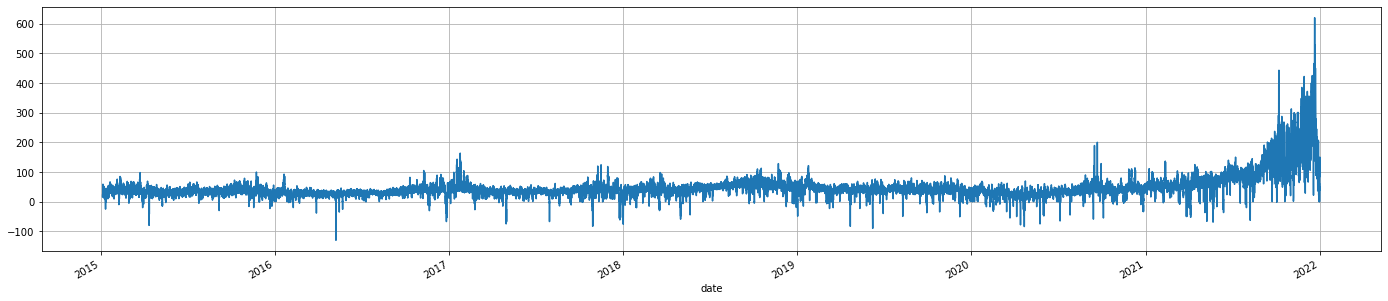

In [4]:
grohandel["Gro_handelspreis[€/MWh]"].plot(figsize=(24,5), grid=True)

Als nächstes werden die Realisierten Erzeugerdaten hinzugefügt. 

In [5]:
 # use your path
all_files = glob.glob(CSV_PATH  + "/Real*.csv")

li = []

for filename in all_files:
    df = pandas.read_csv(filename, delimiter=";", na_values="-", decimal=",", parse_dates={"date":["Datum","Uhrzeit"]}, dayfirst=True)
    li.append(df)

df = pandas.concat(li, axis=0, ignore_index=True)

df = df.set_index("date")

for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.replace(".","")
        df[column] = df[column].str.replace(",",".")
        df[column] = df[column].astype("float")

Erzeugung = df[~df.index.duplicated(keep='first')]# #.resample("4h").sum() #.head(n=10)
Erzeugung = Erzeugung.resample("1h").sum()
Erzeugung

/tmp/ipykernel_8533/2623768455.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column] = df[column].str.replace(".","")


,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Pumpspeicher[MWh],Sonstige Konventionelle[MWh]
date,,,,,,,,,,,,
2015-01-01 00:00:00,4329.0,2918.0,0.0,8193.0,0.0,132.0,10711.0,15688.0,3235.0,2246.0,1526.0,5210.0
2015-01-01 01:00:00,4287.0,2897.0,0.0,8368.0,0.0,123.0,11086.0,15323.0,2366.0,1711.0,1080.0,5182.0
2015-01-01 02:00:00,4324.0,2780.0,0.0,8604.0,0.0,94.0,11026.0,14818.0,2240.0,1564.0,787.0,5292.0
2015-01-01 03:00:00,4346.0,2775.0,0.0,8617.0,0.0,88.0,11028.0,14075.0,2355.0,1554.0,288.0,5272.0
2015-01-01 04:00:00,4342.0,2836.0,0.0,8708.0,0.0,88.0,10963.0,14116.0,2476.0,1557.0,347.0,5244.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 19:00:00,4322.0,0.0,6088.0,16692.0,0.0,148.0,3352.0,7201.0,3974.0,2848.0,3900.0,0.0
2022-01-01 20:00:00,4321.0,0.0,6234.0,17637.0,0.0,148.0,3352.0,6287.0,3577.0,2852.0,3297.0,0.0
2022-01-01 21:00:00,4313.0,0.0,6475.0,18113.0,0.0,148.0,3354.0,5657.0,3133.0,2807.0,1367.0,0.0


<AxesSubplot:xlabel='date'>

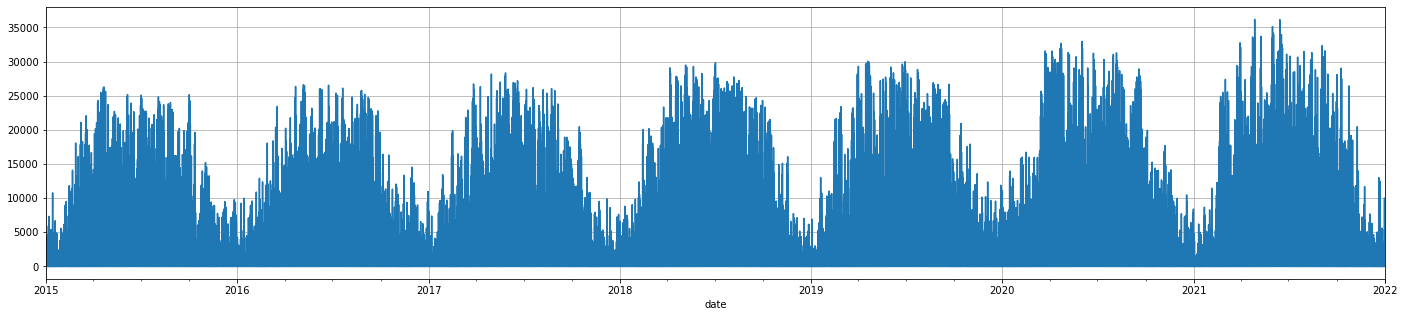

In [6]:
Erzeugung["Photovoltaik[MWh]"].plot(figsize=(24,5), grid=True)

Anschließend kombinieren wir beide Datensätze zu einem Dataframe.

In [7]:
df = pandas.concat([grohandel["Gro_handelspreis[€/MWh]"], Erzeugung["Photovoltaik[MWh]"]], axis=1)
df
#df["neueSpalte"] = df["Photovoltaik[MWh]"] * df["DA_Sp"]#.plot()

,Gro_handelspreis[€/MWh],Photovoltaik[MWh]
date,,
2015-01-01 00:00:00,NaN,0.0
2015-01-01 01:00:00,NaN,0.0
2015-01-01 02:00:00,NaN,0.0
2015-01-01 03:00:00,NaN,0.0
2015-01-01 04:00:00,NaN,0.0
...,...,...
2022-01-01 19:00:00,140.28,0.0
2022-01-01 20:00:00,121.88,0.0
2022-01-01 21:00:00,102.61,0.0


# Importieren der Marktwerte 

Nun definieren wir und ein dictionary mit von uns benötigten Marktwerten. Hier habe ich die Daten händisch zusammen kopiert, da das schneller ging als sie aus vielen unterschiedlichen Quellen mit einem Skript zusammen zu führen.

Aus dem `dict` bauen ich als erstes danach ein Pataframe mit den tatsächlichen Jahreswerten für PV. Pandas kann super aus übergebenen `dict`s ein Dataframe bauen, da DataFrames selber im endeffekt auch nichts anderes sind. Weitere Beschreibung im Code:

In [8]:
marktwerte = {
    "Jahresmarktwerte":{
        "Einheit":"ct/kWh",
        "PV":{
            "Jahr":[2020,2021],
            "Jahresmarktwert":[2.458,7.552]
        },
        "Wind":{
            "Jahr":[],
            "Jahresmarktwert":[]
        }
    },
    "tatsächlicher Jahresmarktwert":{
        "Einheit":"ct/kWh",
        "PV":{
            "Jahr":[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
            "Jahresmarktwert":[4.495,3.936,3.333,3.171,2.956,3.474,4.515,3.776,2.897,9.562, 0],
            "anzulegender Wert":[]
        },
        "Wind":{
            "Jahr":[],
            "Jahresmarktwert":[]
        }

    }
}

############################
anzulegenderWert = 5   #####
############################

lenList = len(marktwerte["tatsächlicher Jahresmarktwert"]["PV"]["Jahr"])
marktwerte["tatsächlicher Jahresmarktwert"]["PV"]["anzulegender Wert"] = [anzulegenderWert] * lenList

PV_marktwerte = pandas.DataFrame(marktwerte["tatsächlicher Jahresmarktwert"]["PV"])
PV_marktwerte

,Jahr,Jahresmarktwert,anzulegender Wert
0,2012,4.495,5
1,2013,3.936,5
2,2014,3.333,5
3,2015,3.171,5
4,2016,2.956,5
5,2017,3.474,5
6,2018,4.515,5
7,2019,3.776,5
8,2020,2.897,5
9,2021,9.562,5


Jetzt ist jeder Eintrag aus dem `dict` eine Spalte in dem neuen DataFrame. 
Als nächstes wollen wir das Datum als `datetime` Datentyp umwandeln und es anschließend als Index setzen, um es später mit unseren anderen Daten zu verschneiden:

In [9]:
PV_marktwerte["Jahr"] = pandas.to_datetime(PV_marktwerte["Jahr"], format="%Y")
PV_marktwerte = PV_marktwerte.rename(columns={"Jahr":"date"})
PV_marktwerte = PV_marktwerte.set_index("date")
PV_marktwerte

,Jahresmarktwert,anzulegender Wert
date,,
2012-01-01,4.495,5
2013-01-01,3.936,5
2014-01-01,3.333,5
2015-01-01,3.171,5
2016-01-01,2.956,5
2017-01-01,3.474,5
2018-01-01,4.515,5
2019-01-01,3.776,5
2020-01-01,2.897,5


Jetzt noch schnell ein Präfix angehangen, damit wir die Spalten später leichter identifizieren können und von ct/kWh in €/MWh umgerechnet:

In [10]:
PV_marktwerte = PV_marktwerte.add_prefix("PV_")
PV_marktwerte = PV_marktwerte.add_suffix(" [€/MWh]")
PV_marktwerte = PV_marktwerte / 100 * 1000 # ct/kWh in €/MWh
PV_marktwerte

,PV_Jahresmarktwert [€/MWh],PV_anzulegender Wert [€/MWh]
date,,
2012-01-01,44.95,50.0
2013-01-01,39.36,50.0
2014-01-01,33.33,50.0
2015-01-01,31.71,50.0
2016-01-01,29.56,50.0
2017-01-01,34.74,50.0
2018-01-01,45.15,50.0
2019-01-01,37.76,50.0
2020-01-01,28.97,50.0


Da die restlichen Daten jedoch eine höhere zeitliche Auflösung haben, müssen wir diese Daten auch noch final *upscalen*. Das bedeutet nichts anderes, als das wir sie wie zuvor die `df.resample()` funktion anwenden. Hier jedoch hin zu einer höheren zeitlichen Auflösung `"1Y"`  zu `"1h"`. Da wir hier nicht mit `.sum()` oder `.mean()` die entstandenen Lücken füllen können, nutzen wir eine sogenannte *forward fill* funktion. Diese hießt in Pandas `.ffill()` und fügt in Leerstellen den letzten Wert ein, bis ein neuer kommt.
Dann nehmen wir mit `[:-1]` noch den letzten Wert aus der Zeitreihe. Diesen für 2022 hatte ich nur eingefügt, damit im `.ffill()` auch das ganze Jahr 2021 aufgefüllt werden konnte. Ohne den einen Wert von 2022, wäre nach dem upscalen mit `.resample("1h").ffill()` nach dem `2021-01-01` schluss gewesen, da nicht zu einem nächst höheren Wert aufzufüllen gewesen wäre.

In [11]:
PV_marktwerte = PV_marktwerte.resample("1h").ffill()[:-1]
PV_marktwerte

,PV_Jahresmarktwert [€/MWh],PV_anzulegender Wert [€/MWh]
date,,
2012-01-01 00:00:00,44.95,50.0
2012-01-01 01:00:00,44.95,50.0
2012-01-01 02:00:00,44.95,50.0
2012-01-01 03:00:00,44.95,50.0
2012-01-01 04:00:00,44.95,50.0
...,...,...
2021-12-31 19:00:00,95.62,50.0
2021-12-31 20:00:00,95.62,50.0
2021-12-31 21:00:00,95.62,50.0


# Berechnung von CFD-Daten

Nun füllen wir alle Daten zusammen und führen die Berechungen wie in deiner Excel-Tabelle durch. Das Verbinden machen wir hier zusätzlich über die Option *`join="inner"`*. Das bedeutet, dass Nur die Zeilen genommen werden, die laut dem Index in beiden DataFrames vorhanden sind. Hier Also Daten von 2018 - 2021. 

Anders als bei Excel, verwende ich hier für jahresspezifische Werte ganze Spalten anstatt einzelne Variablen. Das vereinfacht das Rechnen mit unterschiedlichen Spalten enorm, da du dann du in Pandas einfach gleich großen Spalten mit Basisopperationen wie `*, /, +, -, <, &, ...` verschneiden kannst.

The `numpy.where()` function will in this case be our equivalent to excels `if` for a entire DataFrame.

In [12]:
dfz = pandas.concat([PV_marktwerte, df], axis=1, join="inner")
#dfz = load_smard_data(ee_type = "Photovoltaik", anzulegender_Marktwert = 5.0)
#dfz

In [13]:
dfz[dfz <= 0].count()

PV_Jahresmarktwert [€/MWh]          0
PV_anzulegender Wert [€/MWh]        0
Gro_handelspreis[€/MWh]          1155
Photovoltaik[MWh]               25715
dtype: int64

Next we want to analyze a condition on *n* prior time steps in out Dataframe. For example:

Was the generated Power by PV during the last *4 hours* was greater than *some value*?

Therefore we are going to use the `.rolling()` function of a `pandas.Dataframe`. This function will apply a moving window to our passed `Dataframe` (2D) or Series (1D). The size of the window is given by the `window=` argument and can either be an `int` representing a number of raws or columns, or a `str` in a valid timeframe format (`4h` for 4 hours, `4d` for 4 days, ...). 
Next you can chose if you want the window to apply for all prior values (`center = False`), or all surrounding values (`center = True`). Finally we can chose whether we want to include the first or last value of the window with the `closed=` argument. 

If `right`, the first point in the window is excluded from calculations.

If `left`, the last point in the window is excluded from calculations.

If `both`, the no points in the window are excluded from calculations.

If `neither`, the first and last points in the window are excluded from calculations.

After the `.rolling()` function we lastly need to specify a aggregation function to use on the vales inside the window. Basic functions would be `.sum()`, `.mean()`, `.median()`, `.count()`.

In [14]:
timeframe = "4h"

# Make a boolean mask on all raws, where Großhandeslpreis < negative PV_anzulegender Wert [€/MWh]
dfz[f"Gro_handelspreis_limited [€/MWh]"] = dfz["Gro_handelspreis[€/MWh]"] <= (- 1 * dfz["PV_anzulegender Wert [€/MWh]"])

# Checks if the n recent raws where True(Großhandel < 0). If yes, return True, else False. The result is a mask which filters the hours,
# where the n recent hours were negative
dfz[f"Gro_handelspreis_limited [€/MWh]"] = dfz[f"Gro_handelspreis_limited [€/MWh]"].rolling(window=timeframe, center=False, closed="right").min().astype(bool)
# same as:
#dfz[f"Gro_handelspreis_limited [€/MWh]"] = dfz["Gro_handelspreis_limited [€/MWh]"].rolling(window=timeframe, center=False, closed="right").apply(lambda x: x.all(), raw=False)

dfz[f"Gro_handelspreis_limited [€/MWh]"] = numpy.where(dfz[f"Gro_handelspreis_limited [€/MWh]"], 0, dfz["Gro_handelspreis[€/MWh]"])

In [114]:
dfz.loc[dfz["Gro_handelspreis[€/MWh]"] <= (- 1 * dfz["PV_anzulegender Wert [€/MWh]"])]

,PV_Jahresmarktwert [€/MWh],PV_anzulegender Wert [€/MWh],Gro_handelspreis[€/MWh],Photovoltaik[MWh],Gro_handelspreis_limited [€/MWh],Gro_handelspreis_limited_new [€/MWh]
date,,,,,,
2015-04-12 13:00:00,31.71,50.0,-65.06,20588.0,2.0,10.0
2015-04-12 14:00:00,31.71,50.0,-79.94,19743.0,3.0,10.0
2015-04-12 15:00:00,31.71,50.0,-65.02,17972.0,4.0,10.0
2016-05-08 12:00:00,29.56,50.0,-76.09,26473.0,3.0,10.0
2016-05-08 13:00:00,29.56,50.0,-100.06,26453.0,4.0,10.0
...,...,...,...,...,...,...
2021-05-22 13:00:00,95.62,50.0,-68.00,22197.0,10.0,10.0
2021-05-22 14:00:00,95.62,50.0,-69.00,21180.0,11.0,10.0
2021-05-22 15:00:00,95.62,50.0,-62.83,19325.0,12.0,10.0


<AxesSubplot:xlabel='date'>

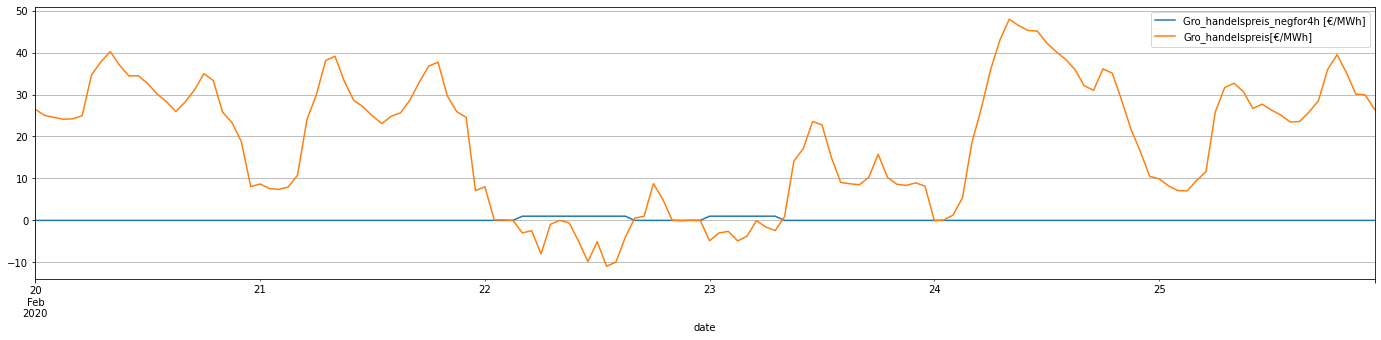

In [120]:
# 1 if Groh negativ, else nan
v = numpy.where(dfz["Gro_handelspreis[€/MWh]"] < 0, 1, numpy.nan)
# Bool mask where nan
n = numpy.isnan(v)
# reverse mask to True where Groh negativ
a = ~n
# count +1 if a is True -> Groh negativ
c = numpy.cumsum(a)
# calculate difference out[i] = a[i+1] - a[i]
d = numpy.diff(numpy.concatenate(([0.], c[n])))
# 
v[n] = -d
# counts the length of the events
dfz["Gro_handelspreis_limited [€/MWh]"] = abs(numpy.cumsum(v))
# make events < 4 
dfz["Gro_handelspreis_limited_new [€/MWh]"] =  numpy.where(dfz[f"Gro_handelspreis_limited [€/MWh]"] < 4, 0, dfz[f"Gro_handelspreis_limited [€/MWh]"])
dfz["Gro_handelspreis_limited_new [€/MWh]"] = dfz["Gro_handelspreis_limited_new [€/MWh]"].iloc[::-1].rolling(4).sum().iloc[::-1]
dfz["Gro_handelspreis_negfor4h [€/MWh]"] = numpy.where(dfz["Gro_handelspreis_limited_new [€/MWh]"] > 0, 1, 0)
dfz["PV_anzulegender Wert [€/MWh]"] = numpy.where(dfz["Gro_handelspreis_negfor4h [€/MWh]"] == 1, 0,  dfz["PV_anzulegender Wert [€/MWh]"])
#dfz["Gro_handelspreis_limited [€/MWh]"].rolling(4).sum().loc["2020-02":"2020-03"].iloc[:40]#.plot(figsize=(24,5), grid=True)
dfz[["Gro_handelspreis_negfor4h [€/MWh]","Gro_handelspreis[€/MWh]"]].loc["2020-02-20":"2020-02-25"].plot(figsize=(24,5), grid=True)

Etwas anders ist nur wieder das Einbringen von Jahressummen. Hier erstelle ich die Jahressummen wieder über `df.resample("1Y).sum()`. Das Ergebniss ist jedoch ein DataFrame mit einem Wert pro Jahr. Hier müssen wir wieder die alte zeitliche Auflösung herstellen. Da wir aber nicht wieder ein Wert für 2022 haben, können wir nicht mit `.resample("1h").ffill()` arbeiten. Als Lösung Loope ich über jedes Jahr in dem zeitlich hoch aufgelösten `df` und fülle die Spalte `"Jahreserzeugung"` mit dem für der entsprechend gennerierten Jahressumme.


In [ ]:
# Berechnung der Marktprämie
dfz["Auszahlung MP"] = numpy.where((dfz["PV_anzulegender Wert [€/MWh]"] > dfz["PV_Jahresmarktwert [€/MWh]"]) & (dfz["PV_anzulegender Wert [€/MWh]"] > 0), dfz["PV_anzulegender Wert [€/MWh]"] - dfz["PV_Jahresmarktwert [€/MWh]"], 0)
dfz["Erlöse [€/MWh]"] = numpy.where(dfz["Photovoltaik[MWh]"] == 0, 0, dfz["Gro_handelspreis_limited [€/MWh]"] + dfz["Auszahlung MP"])

dfz["Jahreserzeugung"] = None
jahreswerte = dfz["Photovoltaik[MWh]"].resample("Y").sum()

for year in jahreswerte.index.year:
    dfz.loc[str(year),"Jahreserzeugung"] = jahreswerte.loc[str(year)].values[0]

dfz["Erlös gesammt"] = dfz["Photovoltaik[MWh]"] * dfz["Erlöse [€/MWh]"]
dfz["Erlös nominal"] = dfz["Erlös gesammt"] / dfz["Jahreserzeugung"]

# Definition/Berechnung CFDs
dfz["CFD-Prämie"] = dfz["PV_anzulegender Wert [€/MWh]"] - dfz["PV_Jahresmarktwert [€/MWh]"]

dfz.head(n=10)

# Export to Excel

Here we are going to export our `pandas.DataFrame` to an excel file using the `DataFarem.to_excel()` method. In this exapmle we will export a excel file with either a single or multiple sheets. 

The new file will be generated to the passed directory. If you just pass a name without directories, the files will be placed in the same directory as the python file or notebook, running the `.to_excel()` command.

In [ ]:
# SINGEL SHEET

dfz.to_excel("single_sheet.xlsx")

In [ ]:
# MULTIPLE SHEETS

with pandas.ExcelWriter('multiple_sheet.xlsx') as writer:  
    dfz.to_excel(writer, sheet_name='data')
    dfz["CFD-Prämie"].to_excel(writer, sheet_name='nur CFDs')
    dfz.resample("Y").mean().to_excel(writer, sheet_name='Jahresmittel')
    dfz.resample("W").mean().to_excel(writer, sheet_name='Wöchentlichesmittel')

# Download Data from remote vscode to your local computer

To download a file from a remote server to your local machine, locate the new file in the explorer on the left side of vscode. Right-Click on the file a left-click on `Herunterladen` or `Download`. Next you should get a window to specify the download directory.